In [2]:
import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import PollingSystem as PS
import MarkovianRP as MRP
import dtr
import motion
import sim_template as sim
from importlib import reload 
import TSPN

In [3]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


In [4]:
#If we're feeling it
if False:
    %store -r dt_sys AORP TSPNP tjcps pjcps qBase region pcs pfs pjcps prob_pred_con ccs cfs true_joint_con_fields tjcps

In [5]:
#Setup the communication environment:

#For now, use same channel params, basd on the San Francisco measurements
nPL = 5.2 # per SF data should be in [2, 10]
kPL = -20 # per SF data, [-20, 90]

decorrSH = 2.09    
alpha = 9 # per SF data [4,100]%too high - worse prediction
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.5



#6 remote stations
l = 18.5
l_inner=5
c = np.array([25, 25])

qBase = np.array([c+l_inner*np.array([-(np.sqrt(3)/2), -1/2]), c+(l_inner+l)*np.array([-(np.sqrt(3)/2), -1/2]), 
                  c+l_inner*np.array([(np.sqrt(3)/2), -1/2]), c+(l_inner+l)*np.array([(np.sqrt(3)/2), -1/2]),
                  [25, 25+l_inner], [25, 25+l_inner+l]])


sub_regions = [[25, 0, 30, 5],
               [50, 24, 30, 5],
               [45, 15, 50, 30]]



cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 50
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 10
n=3
p_th = 0.5

bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)
print(qBase)

[[20.66987298 22.5       ]
 [ 4.64840301 13.25      ]
 [29.33012702 22.5       ]
 [45.35159699 13.25      ]
 [25.         30.        ]
 [25.         48.5       ]]


In [5]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH, sub_regions)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...


KeyboardInterrupt: 

In [ ]:
reload(sim)
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)

print(prob_pred_con)

In [ ]:
reload(sim)
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
els = np.array([0.05, 0.05, 0.05])/beta
dt_sys = dtr.DTR(pcs, region, els, beta, th = GAMMA_TH, p_th=p_th)
ps = dt_sys.ps

In [ ]:
reload(sim)
#######################
#Now increase PL base line
#######################
MOBILE_TX_POWER2 = qos.Pwr(23)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
GAMMA_TH2 = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER2)
cfs2, true_joint_con_fields2, tjcps2 = sim.find_true_conn(ccs, GAMMA_TH2)
pfs2, pjcps2 = sim.find_pred_conn(pcs, GAMMA_TH2, p_th)

# sim.plotCFwithOverlay(n, tjcps2, pjcps2, qBase, region)
# plt.gca().invert_yaxis()
# plt.show()

dt_sys2 = dtr.DTR(pcs, region, els, beta, th = GAMMA_TH2, p_th=p_th)

AORP2 = sim.calc_AORP(dt_sys2, v)

In [7]:
fig_power_comp = "FIG_eq_tri_power_trends.npz"
if False:
    np.savez(fig_power_comp, aorpx = AORP['X'], aorppi = AORP['pi'], aorpx2 = AORP2['X'], aorppi2 = AORP2['pi'],
             tjcps = tjcps, pjcps=pjcps, tjcps2 = tjcps2, pjcps2=pjcps2)

In [8]:
if True:
    fig_pwr = np.load(fig_power_comp, allow_pickle = True)
    AORP = {"X":fig_pwr["aorpx"], "pi":fig_pwr["aorppi"]}
    tjcps = fig_pwr["tjcps"]
    pjcps = fig_pwr["pjcps"]
    
    AORP2 = {"X":fig_pwr["aorpx2"], "pi":fig_pwr["aorppi2"]}
    tjcps2 = fig_pwr["tjcps2"]
    pjcps2 = fig_pwr["pjcps2"]
    MOBILE_TX_POWER2 = qos.Pwr(23)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


[[0.         0.49202395 0.50797605]
 [0.52752511 0.         0.47247489]
 [0.53547001 0.46452999 0.        ]]
[0.3470587  0.32370249 0.32923881]
[[ 0.         22.81161985 22.19842337]
 [22.81161985  0.         24.77458375]
 [22.19842337 24.77458375  0.        ]]


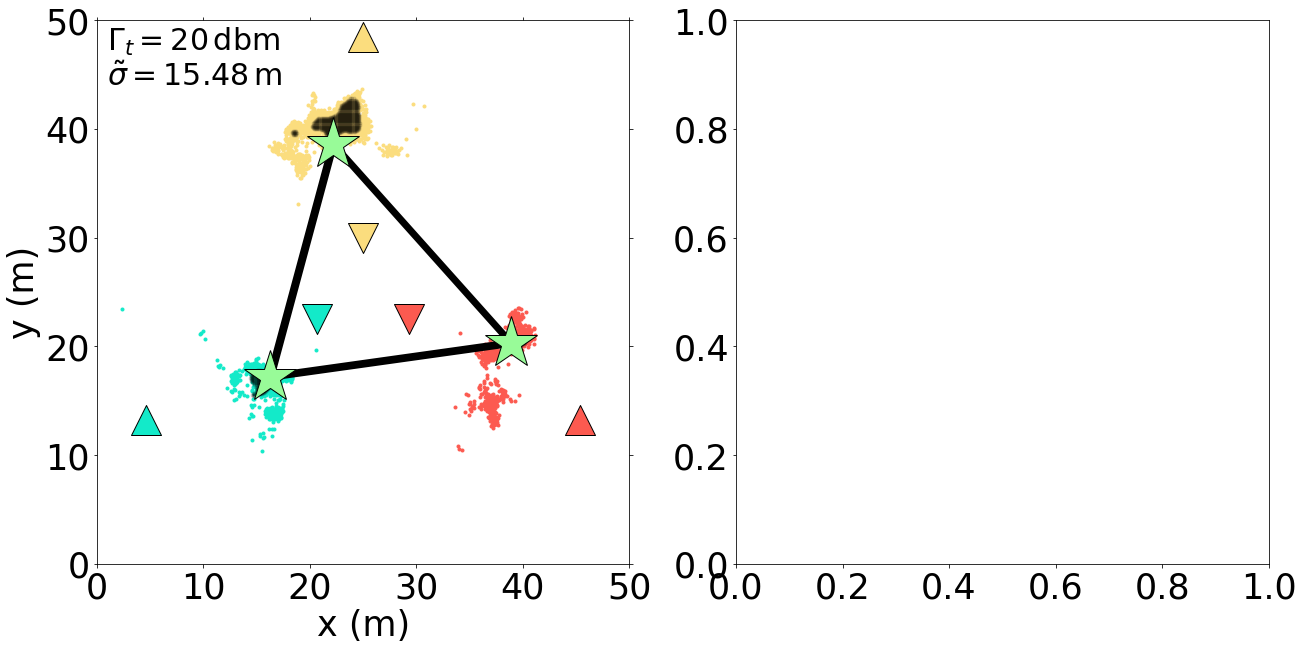

In [9]:
reload(sim)
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 35})

figA, axsA = plt.subplots(1,2, figsize=(21, 10))
pi=AORP['pi']
ax = axsA[0]
ax.clear()
sim.plot_relay_regions(n, tjcps, pjcps, rhos = None, pi = None, ax = ax)
sim.plot_bs(qBase, ax)
sim.set_lims(region, ax)
sim.plot_AORP_routes(AORP, ax)
ax.invert_yaxis()
ax.set_ylabel('y (m)')
ax.set_xlabel('x (m)')
S = dtr.XtoS(AORP['X'])
P_tilde, pi_tilde = sim.pi_to_P(pi)
print(P_tilde)
print(pi_tilde)
label = "$\Gamma_t = %.0f\,$dbm\n$\\tilde{\sigma} = %.2f\,$m"%(MOBILE_TX_POWER.dBm, pi_tilde.T@ S @ pi_tilde)
ax.annotate(label, xy=(0.02,0.88),xycoords='axes fraction',fontsize=30)

# label1 = '$\\rho_%d = %.2f$, $\\tilde{\\pi}_%d = %.2f$'%(1, els[0]*beta, 1, pi_tilde[0])
# label2 = '$\\rho_%d = %.2f$, $\\tilde{\\pi}_%d = %.2f$'%(2, els[1]*beta, 2, pi_tilde[1])
# label3 = '$\\rho_%d = %.2f$, $\\tilde{\\pi}_%d = %.2f$'%(3, els[2]*beta, 3, pi_tilde[2])
# label = label1 +"\n" + label2 + "\n" + label3
# ax.annotate(label, xy=(0.02,0.02),xycoords='axes fraction',
#  fontsize=30)
print(S)

In [10]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 35})

ax = axsA[1]
ax.clear()
sim.plot_relay_regions(n, tjcps2, pjcps2, rhos = None, pi = None, ax = ax)
sim.plot_bs(qBase, ax)
sim.set_lims(region, ax)
sim.plot_AORP_routes(AORP2, ax)
ax.invert_yaxis()
ax.set_ylabel('y (m)')
ax.set_xlabel('x (m)')
pi = AORP2['pi']
P_tilde, pi_tilde = sim.pi_to_P(pi)
print(P_tilde)
print(pi_tilde)
S = dtr.XtoS(AORP2['X'])
label = "$\Gamma_t = %.0f\,$dbm\n$\\tilde{\sigma} = %.2f\,$m"%(MOBILE_TX_POWER2.dBm, pi_tilde.T@ S @ pi_tilde)
ax.annotate(label, xy=(0.02,0.88),xycoords='axes fraction',fontsize=30)

# label1 = '$\\rho_%d = %.2f$, $\\tilde{\\pi}_%d = %.2f$'%(1, els[0]*beta, 1, pi_tilde[0])
# label2 = '$\\rho_%d = %.2f$, $\\tilde{\\pi}_%d = %.2f$'%(2, els[1]*beta, 2, pi_tilde[1])
# label3 = '$\\rho_%d = %.2f$, $\\tilde{\\pi}_%d = %.2f$'%(3, els[2]*beta, 3, pi_tilde[2])
# label = label1 +"\n" + label2 + "\n" + label3
# ax.annotate(label, xy=(0.02,0.02),xycoords='axes fraction',
#  fontsize=30)
print(dtr.XtoS(AORP['X']))
print(dtr.XtoS(AORP2['X']))

[[0.         0.57853488 0.42146512]
 [0.53419069 0.         0.46580931]
 [0.45517435 0.54482565 0.        ]]
[0.3323414  0.35992969 0.30772891]
[[ 0.         22.81161985 22.19842337]
 [22.81161985  0.         24.77458375]
 [22.19842337 24.77458375  0.        ]]
[[ 0.         17.60284068 22.54173906]
 [17.60284068  0.         19.94617758]
 [22.54173906 19.94617758  0.        ]]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


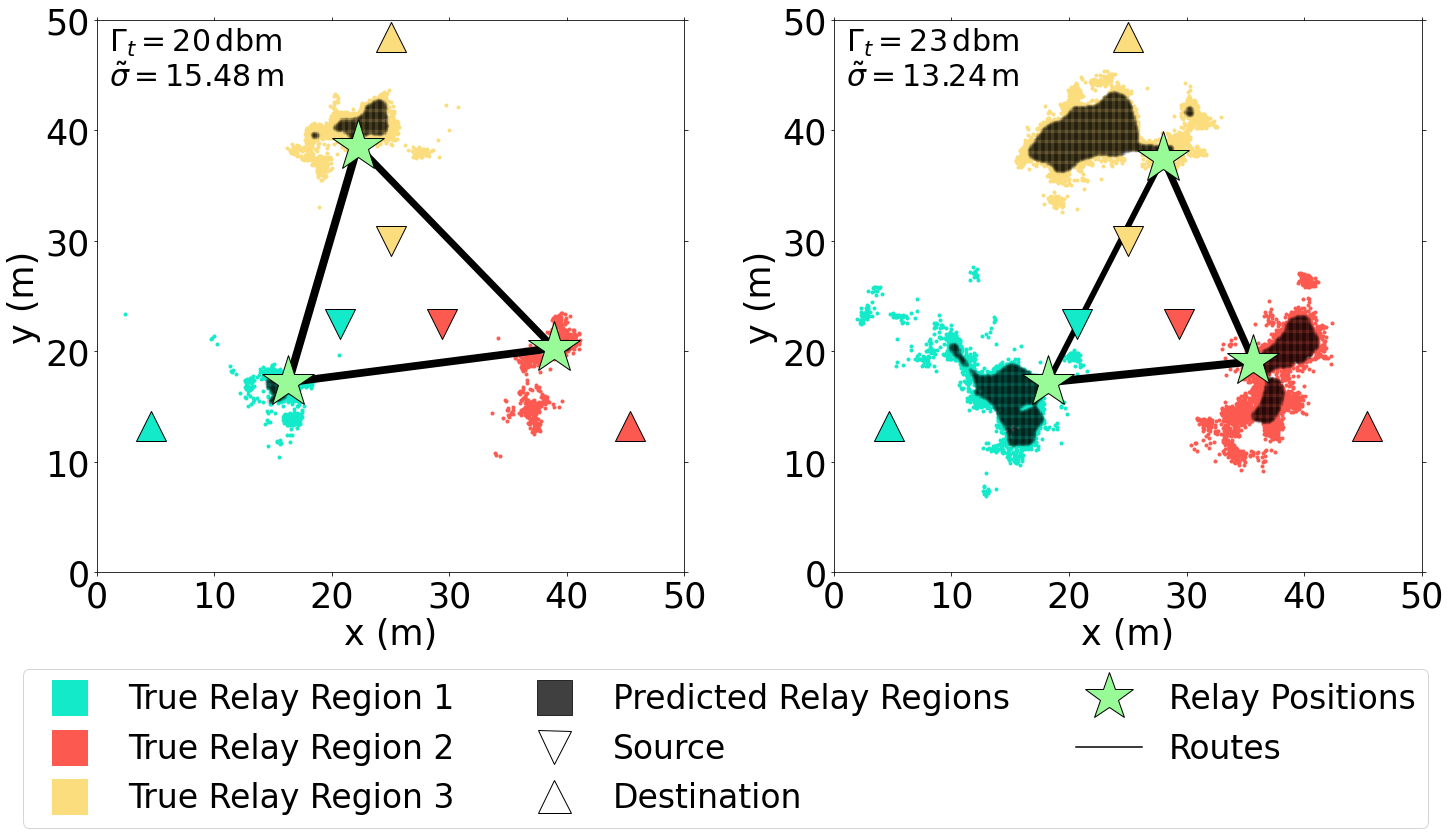

In [14]:
legend.remove()
handles, labels = axsA[1].get_legend_handles_labels()
legend = figA.legend(handles, labels, loc='upper center', bbox_to_anchor=[0.5,0.05], ncol=3, prop={"size":33})
figA.tight_layout()
figA


In [15]:
figA.savefig("FIG_TXpwr_variance.png", format='png', bbox_inches='tight')
figA.savefig("FIG_TXPwr_variance.eps", format='eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
5 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
2 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
9 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
5 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
2 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
12 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
Info: Reduced Poly only contains two points. Reduction ignored
Poly: ([15.9 13.9])  ([16. 14.])  ([15.9 14. ]) Is Interior: False
8 total subregions
E

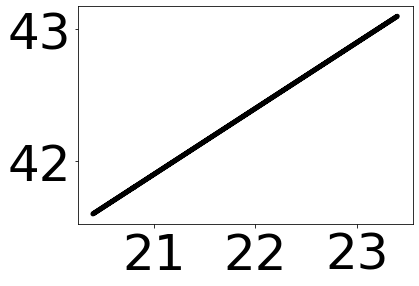

7 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
9 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
11 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
14 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Found hole
Constructed 2 possibly non-convex polygons
14 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
12 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
11 total subregions


In [78]:
reload(PC)
reload(dtr)
reload(sim)

#######################
#Now increase PL base line
#######################
v = 1
txpwrdbm = np.arange(20,23.5, 0.5)
wait_times = []
AORPs = []
cregions =[]
for txdbm in txpwrdbm:
    MOBILE_TX_POWER_tr = qos.Pwr(txdbm)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
    GAMMA_TH_tr = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER_tr)

    dt_sys_tr = dtr.DTR(pcs, region, els, beta, th = GAMMA_TH_tr, p_th=p_th)

    AORP_tr = sim.calc_AORP(dt_sys_tr, v)
    wait_times.append(AORP_tr['WT'])
    AORPs.append(AORP_tr)
    cregions.append(dt_sys_tr.cregions)

In [106]:
if True:
    tx_trends_wt_fn = "eq_tri_power_wt_trends.npz"
    np.savez(tx_trends_wt_fn, txpwrdbm=txpwrdbm, wait_times=wait_times)

In [107]:
if True:
    wr_trends_data = np.load(tx_trends_wt_fn, allow_pickle=True)
    txpwrdbm=wr_trends_data["txpwrdbm"]
    wait_times = wr_trends_data["wait_times"]

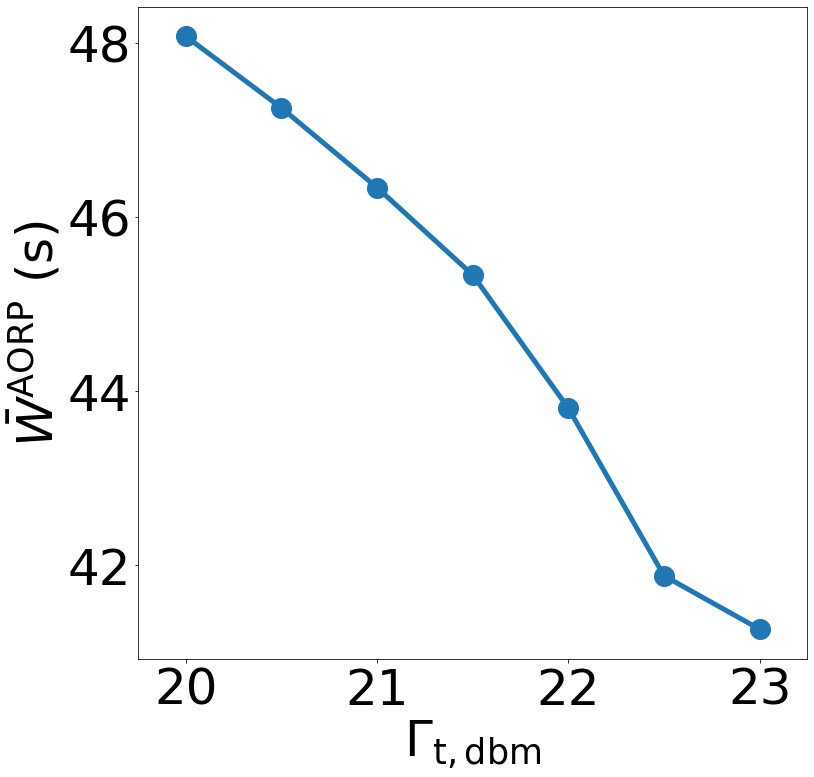

In [108]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 50})
#wait_times = [AORP_tr['WT'] for AORP_tr in wait_times]
plt.figure(figsize=(12,12))
plt.plot(txpwrdbm, wait_times, '-o', linewidth=5, markersize=20)
#plt.ylabel("Average Wait Time (s)")
plt.ylabel("$\\bar{W}^{\\mathrm{AORP}}$ (s)")
#plt.xlabel("TX Power (dbm)")
plt.xlabel("$\\Gamma_\mathrm{t, dbm}$")
plt.xlim(19.75,23.25)

plt.savefig("FIG_TXpwr_trends.png", format='png', bbox_inches='tight')
plt.savefig("FIG_TXPwr_trends.eps", format='eps', bbox_inches='tight')

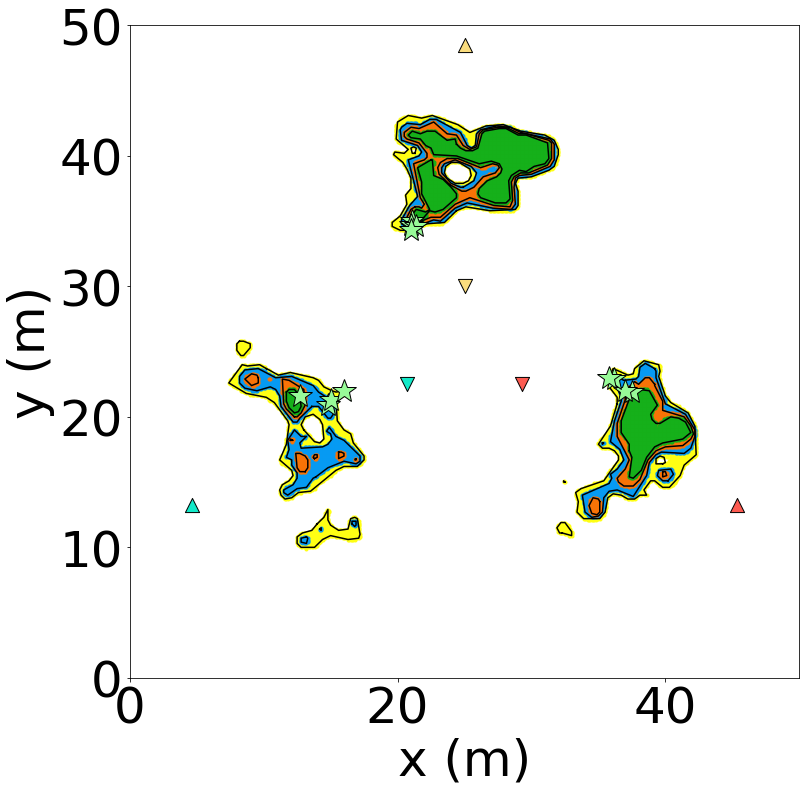

In [82]:
#might work for if we had more room (e.g. slides)

reload(sim)
n_pwrs = len(txpwrdbm)
alphas = np.linspace(0.01, 0.1, n_pwrs)

fig = plt.figure(figsize=(12,12))
ax = plt.gca()
sim.plot_bs(qBase, ax)
sim.set_lims(region, ax)
sim.label_axes(ax)
for k in range(n_pwrs):
    cregs = cregions[k]
    for l in range(3):
        pts = reg.points
        reg = cregs[l]
        reg.plot_polys(show_partition=False)
        pts = reg.points
        plt.plot(pts[:,0],  pts[:,1], '.', color=sim.COLORS[k+3], zorder=-100-k)
    sim._plot_relay_points(AORPs[k]['X'], ax)
ax.invert_yaxis()
for k in range(n_pwrs):
    plt.plot([-100], [-100], '.', color=sim.COLORS[k+3], label="TX Power = %d dbm"%(txpwrdbm[k]), markersize=20)
#ax.legend()

In [56]:
n_pwrs

7

In [57]:
len(sim.COLORS)

8